# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
The goal of this project is detecting of lane lines in road images and videos using Python and OpenCV. 

These are the steps to detect left and right lanes in a road image:

 1- Convert color image to grayscale
 
 2- Apply Gaussian smoothing
 
 3- Edge Detection using Canny
 
 4- Region selection using fillpoly and mask the image 
 
 5- Line detectin using Hough transoform on edge detected image
 
 6- Finding left and right lanes (by slope ((y2-y1)/(x2-x1))) 
 
 7- Average the position of each of the lines and extrapolate to the top and bottom of the lane.
 
 8- Draw lanes on the original image
 
 9- Save the result (image or video)

## Import Packages

In [23]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


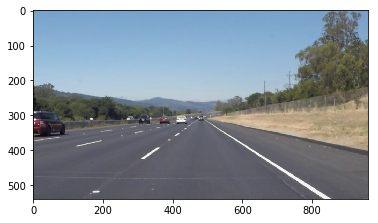

In [24]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)
#image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#plt.imshow(image, cmap='gray')  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Following OpenCV functions are used in this project:**


`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

## Helper Functions

These helper functions are used in this project:

In [25]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending 
    #on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines_first_method(img, lines, color=[255, 0, 0], thickness=4):
    """
    The first method for finding left and right lanes based on averaging 
    and extrapolating. It does not work very well on all images
    """
    imshape = image.shape
    m_left, c_left,x0_left, y0_left = 0 , 0 , 0 , 0
    m_right, c_right, x0_right, y0_right = 0, 0 , 0 , 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            m =((y2-y1)/(x2-x1))
            if m < 0:
                m_left = m_left + m
                c_left = c_left+1
                x0_left = x0_left + x1 + x2
                y0_left = y0_left + y1 + y2
            else:
                m_right = m_right + m
                c_right = c_right + 1
                x0_right = x0_right + x1 + x2
                y0_right = y0_right + y1 + y2
                
    m_left = m_left/c_left
    m_right = m_right/c_right
    x0_left = x0_left/(2*c_left)
    y0_left = y0_left/(2*c_left)
    x0_right = x0_right/(2*c_right)
    y0_right = y0_right/(2*c_right)
    
    
    y_left_bottom = imshape[0]
    x_left_bottom = int((y_left_bottom - y0_left)/m_left + x0_left)
    y_right_bottom = imshape[0]
    x_right_bottom = int((y_right_bottom - y0_right)/m_right + x0_right)
    
    y_left_top = 290
    x_left_top = int((y_left_top - y0_left)/m_left + x0_left)
    y_right_top = 290
    x_right_top = int((y_right_top - y0_right)/m_right + x0_right)
    
    
    cv2.line(img, (x_left_bottom, y_left_bottom), (x_left_top, y_left_top),
             color, thickness)
    cv2.line(img, (x_right_bottom, y_right_bottom), (x_right_top, y_right_top),
             color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):

    return cv2.addWeighted(initial_img, α, img, β, λ)

In [26]:
def line_points(y1, y2, line):

    if line is None:
        return None
    
    slope, intercept = line

    x1 = int((y1 - intercept)/slope) # point1 x
    x2 = int((y2 - intercept)/slope) # point2x
    y1 = int(y1)#point1 y
    y2 = int(y2)#point2 y
    
    return ((x1, y1), (x2, y2))

def draw_lines_2nd_method(img, lines, color=[255, 0, 0], thickness=4):
    left_lines , left_weights    = []  , []
    right_lines, right_weights   = []  , []

    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if not x2==x1: # not vertical lines
                
                slope = (y2-y1)/(x2-x1)
                intercept = y1 - slope*x1
                length = np.sqrt((y2-y1)**2+(x2-x1)**2)
                if slope < 0: # left line 
                    left_lines.append((slope, intercept))
                    left_weights.append((length))
                else: # right line
                    right_lines.append((slope, intercept))
                    right_weights.append((length))
    if len(left_weights) >0:
        left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)   
    else:
        None
        
    if len(right_weights)>0:
        right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights)  
    else:
        None
        
    left_line_points  = line_points(image.shape[0], image.shape[0]*.6, left_lane)
    right_line_points = line_points(image.shape[0], image.shape[0]*.6, right_lane)
 
    line_image = np.zeros_like(image)
    cv2.line(line_image, left_line_points,  color, thickness)
    cv2.line(line_image, right_line_points,  color, thickness)
    
    result = cv2.addWeighted(image, 1.0, line_image, 0.90, 0.0)
    return result

In [27]:
# This function accepts an image as input and return an image with detected 
#left and right lanes

def process_image(image):
    
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    #gray = grayscale(image)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    #blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    #edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    bottom_left  = [imshape[1]*0.1, imshape[0]*0.95]
    top_left     = [imshape[1]*0.4, imshape[0]*0.6]
    bottom_right = [imshape[1]*0.9, imshape[0]*0.95]
    top_right    = [imshape[1]*0.6, imshape[0]*0.6] 
    vertices = np.array([[bottom_left, top_left,top_right,bottom_right]],
                        dtype=np.int32)
    
    #cv2.fillPoly(mask, vertices, ignore_mask_color)
    #masked_edges = cv2.bitwise_and(edges, mask)
    masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 300    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    lines = hough_lines(masked_edges, rho, theta, threshold,
                        min_line_length, max_line_gap)
    
    left_right_lanes = left_right_lane_lines(image, lines)
    result = draw_lane_lines(image, left_right_lanes)

    return result

## Test Images

There are six different images in the test images folder. Each image is sent to the left and right lane detectin pipline and the results are saved in the output test images folder.

In [28]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Each test image is read and processed in lane finding pipeline.

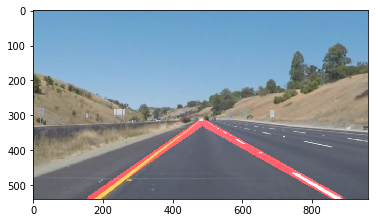

In [29]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
import time

directory = 'test_images_output'
if not os.path.exists(directory):
    os.makedirs(directory)
    
images_list = os.listdir("test_images/")

for image_name in images_list:
    image = mpimg.imread('test_images/'+image_name)
    output_image = process_image(image)
    plt.imshow(output_image)
    
    cv2.imwrite(directory + '/output_'+ image_name ,
                cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR) )

## Test on Videos

After drwing lanes over images, we use the pipeline to draw lanes on videos. 

There are two video samples:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`


In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [31]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
video_directory = 'test_videos_output'
if not os.path.exists(video_directory):
    os.makedirs(video_directory)
## To speed up the testing process you may want to try your pipeline on a shorter 
#subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and 
#end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 45.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.18 s, sys: 410 ms, total: 2.59 s
Wall time: 5.66 s


The output video

In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [33]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:17<00:00, 39.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 7.19 s, sys: 1.8 s, total: 8.99 s
Wall time: 18.3 s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))